In [1]:
# importing library
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout,BatchNormalization,SeparableConv2D
from keras.preprocessing.image import ImageDataGenerator
from collections import Counter, OrderedDict
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [2]:
from keras.layers import Embedding
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, LeakyReLU
from keras.layers import Flatten, Conv1D, SpatialDropout1D, MaxPooling1D,AveragePooling1D, merge, concatenate, Input, Dropout

from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules



In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# checking for number of images in training
files = []
directory = ''
for dirname, _, filenames in os.walk('/Users/melody/Desktop/Machine Learning/Project/severstal-steel-defect-detection/train_images'):
    files = filenames
    directory = dirname

In [5]:
len(files)

12568

In [6]:
# creating dataframe that lists ImageId for training images
file_df = pd.DataFrame(files, columns = ['ImageId'])

In [7]:
# checking for number of images that have defects in training from csv file
data = pd.read_csv("/Users/melody/Desktop/Machine Learning/Project/severstal-steel-defect-detection/train.csv")
data.shape

(7095, 3)

In [8]:
data.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64

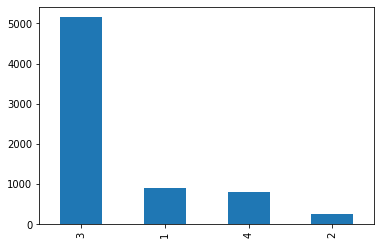

In [9]:
# Checking the classes of the images in training
data["ClassId"].value_counts().plot(kind = 'bar')
data["ClassId"].value_counts()

In [10]:
# Creating dataframe that shows the multi-labels of classes classification of the images
data['ones'] = 1
pivot = data[['ImageId','ClassId','ones']].pivot(index='ImageId', columns='ClassId',values='ones').reset_index()
file_df = file_df.merge(pivot, how='left', on='ImageId').fillna(0)
file_df.shape
file_df.head()

,ImageId,1,2,3,4
0,58ee62fd7.jpg,0.0,0.0,1.0,0.0
1,eeffa4c49.jpg,1.0,0.0,1.0,0.0
2,0dced41aa.jpg,0.0,0.0,0.0,0.0
3,bd2366c49.jpg,0.0,0.0,0.0,0.0
4,e2bdd4236.jpg,0.0,0.0,1.0,0.0


In [11]:
# Creating test dataset
df_test = file_df.sample(frac=0.15, random_state=0)
print(df_test.shape)

(1885, 5)


In [12]:
# Creating training dataset
exclude = file_df.index.isin(df_test.index)
df_train = file_df.loc[~exclude]
print(df_train.shape)

(10683, 5)


In [13]:
# Taking training dataset that doesn't include images where have no defect (all 0s for all classes across)
df_train = df_train[(df_train[[1,2,3,4]] != 0).any(axis=1)]
print(df_train.shape)

(5648, 5)


In [14]:
# Replicating rows of data according to class 
df_train['rpt'] = 1 + df_train[1]*4 + df_train[4]*4 + df_train[2]*10 + \
                      df_train[1]*df_train[3]*4 + df_train[2]*df_train[3]*8 + df_train[1]*df_train[2]*4 + \
                      df_train[1]*df_train[2]*df_train[3]*12 + df_train[2]*df_train[4]*12
df_train = df_train.reindex(df_train.index.repeat(df_train.rpt)).reset_index(drop=True).drop(['rpt'],axis=1)
df_train.shape

(14166, 5)

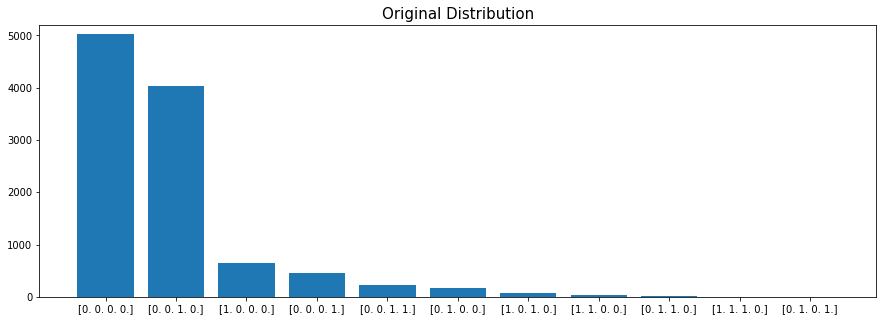

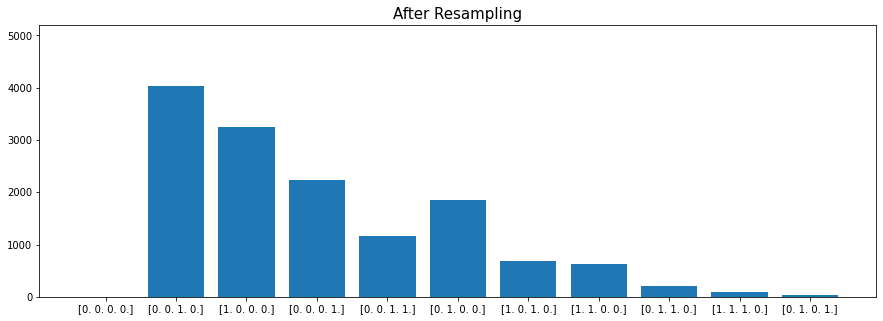

In [15]:
# Visualizing old class distribution of df_train
y_counts_old = file_df.loc[~exclude][[1,2,3,4]].to_numpy()
counts = Counter(str(l) for l in y_counts_old)
counts = OrderedDict(counts.most_common())
counts = pd.DataFrame.from_dict(dict(counts), orient='index')

plt.figure(figsize=(15, 5))
plt.title('Original Distribution', fontsize=15)
plt.ylim(0,5200)
plt.bar(counts.index, counts[0])
plt.show()

# Visualizing new class distribution of df_train
y_counts_new = df_train[[1,2,3,4]].to_numpy()
counts2 = Counter(str(l) for l in y_counts_new)
counts2['[0. 0. 0. 0.]'] = 0
counts2 = pd.DataFrame.from_dict(dict(counts2), orient='index')
counts2 = counts2.loc[counts.index]

plt.figure(figsize=(15, 5))
plt.title('After Resampling', fontsize=15)
plt.ylim(0,5200)
plt.bar(counts2.index, counts2[0])
plt.show()

In [16]:
# Transfroming images 
datagen=ImageDataGenerator(rescale=1./255., shear_range=20.0,
                           rotation_range=10, width_shift_range=0.2, height_shift_range=0.2,
                           horizontal_flip=True, vertical_flip=True, validation_split=0.15)

test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(dataframe=df_train,
                directory='/Users/melody/Desktop/Machine Learning/Project/severstal-steel-defect-detection/train_images', subset="training",
                x_col='ImageId', y_col=[1,2,3,4],
                batch_size=64,
                seed=0, shuffle=True,
                class_mode='raw', color_mode="rgb",
                target_size=(71,71))

valid_generator=datagen.flow_from_dataframe(dataframe=df_train,
                directory='/Users/melody/Desktop/Machine Learning/Project/severstal-steel-defect-detection/train_images', subset="validation",
                x_col='ImageId', y_col=[1,2,3,4],
                batch_size=64,
                seed=0, shuffle=True,
                class_mode='raw', color_mode="rgb",
                target_size=(71,71))

test_generator=test_datagen.flow_from_dataframe(dataframe=df_test,
                directory='/Users/melody/Desktop/Machine Learning/Project/severstal-steel-defect-detection/train_images',
                x_col='ImageId', y_col=[1,2,3,4],
                batch_size=64,
                seed=0, shuffle=True,
                class_mode='raw', color_mode="rgb",
                target_size=(71,71))

Found 12042 validated image filenames.
Found 2124 validated image filenames.
Found 1885 validated image filenames.


# Xception

In [17]:
# Creating Xception layer
Xception = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(71, 71, 3),
    classes=4,
)

Metal device set to: Apple M1


2022-05-30 18:19:51.940878: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-30 18:19:51.941157: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
# Freeze the early convolutional layers of the network and only train the last few layers which make a prediction
for layer in Xception.layers[:-5]:
    layer.trainable=False

In [19]:
# Building Model
xceptionmodel=Sequential()
xceptionmodel.add(Xception)
xceptionmodel.add(Dense(128,activation="relu"))
xceptionmodel.add(Dropout(0.5))
xceptionmodel.add(Flatten())
xceptionmodel.add(Dense(52,activation="relu"))
xceptionmodel.add(Dropout(0.5))
xceptionmodel.add(Dense(52,activation="relu"))
xceptionmodel.add(Dropout(0.5))
xceptionmodel.add(Dense(4,activation="sigmoid"))

In [20]:
# Checking model summary
xceptionmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 dense (Dense)               (None, 3, 3, 128)         262272    
                                                                 
 dropout (Dropout)           (None, 3, 3, 128)         0         
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense_1 (Dense)             (None, 52)                59956     
                                                                 
 dropout_1 (Dropout)         (None, 52)                0         
                                                                 
 dense_2 (Dense)             (None, 52)                2

In [21]:
# Compiling model
xceptionmodel.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy","binary_accuracy"])

In [22]:
# Creating step size 
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)
print(STEP_SIZE_TEST)

188
33
29


In [23]:
# Fitting model with early stop and saving model to path
callback_list = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='./[xception]-{epoch:02d}-{val_loss:.3f}.h5'),
]

history = xceptionmodel.fit(x=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25,
                    callbacks=callback_list,
                    verbose=1)

Epoch 1/25


2022-05-30 18:20:06.541631: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-30 18:20:07.727736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - ETA: 0s - loss: 0.5669 - accuracy: 0.4053 - binary_accuracy: 0.6984

2022-05-30 18:20:54.745183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - 57s 292ms/step - loss: 0.5669 - accuracy: 0.4053 - binary_accuracy: 0.6984 - val_loss: 0.4705 - val_accuracy: 0.5327 - val_binary_accuracy: 0.7760
Epoch 2/25
188/188 [==============================] - 55s 292ms/step - loss: 0.4348 - accuracy: 0.5675 - binary_accuracy: 0.7812 - val_loss: 0.3993 - val_accuracy: 0.6023 - val_binary_accuracy: 0.8028
Epoch 3/25
188/188 [==============================] - 58s 305ms/step - loss: 0.3978 - accuracy: 0.6039 - binary_accuracy: 0.8059 - val_loss: 0.3840 - val_accuracy: 0.5947 - val_binary_accuracy: 0.8175
Epoch 4/25
188/188 [==============================] - 60s 316ms/step - loss: 0.3734 - accuracy: 0.6308 - binary_accuracy: 0.8201 - val_loss: 0.3736 - val_accuracy: 0.6188 - val_binary_accuracy: 0.8266
Epoch 5/25
188/188 [==============================] - 61s 321ms/step - loss: 0.3622 - accuracy: 0.6464 - binary_accuracy: 0.8287 - val_loss: 0.3767 - val_accuracy: 0.6326 - val_binary_accuracy: 0.8324
Epoch 

### Results

In [24]:
# Compiling loss and accuracy for every epoch 
history_df = pd.DataFrame(history.history)
history_df.index += 1

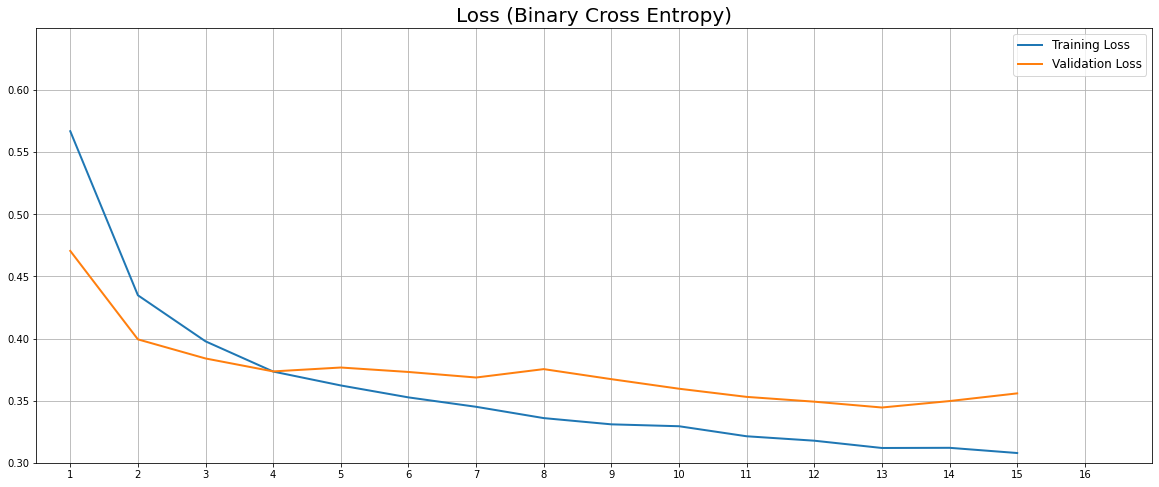

In [30]:
# Plot Loss 
plt.subplots(figsize=(20,8))
plt.plot(history_df.loc[:, ['loss','val_loss']], lw=2)
plt.title('Loss (Binary Cross Entropy)', fontsize=20)
plt.legend(['Training Loss','Validation Loss'], fontsize=12, loc=1)
plt.xlim(0.5,17)
plt.ylim(0.45,0.65)
plt.xticks(np.arange(1, 17, step=1))
plt.yticks(np.arange(0.3, 0.65, step=0.05))
plt.grid()
plt.show()

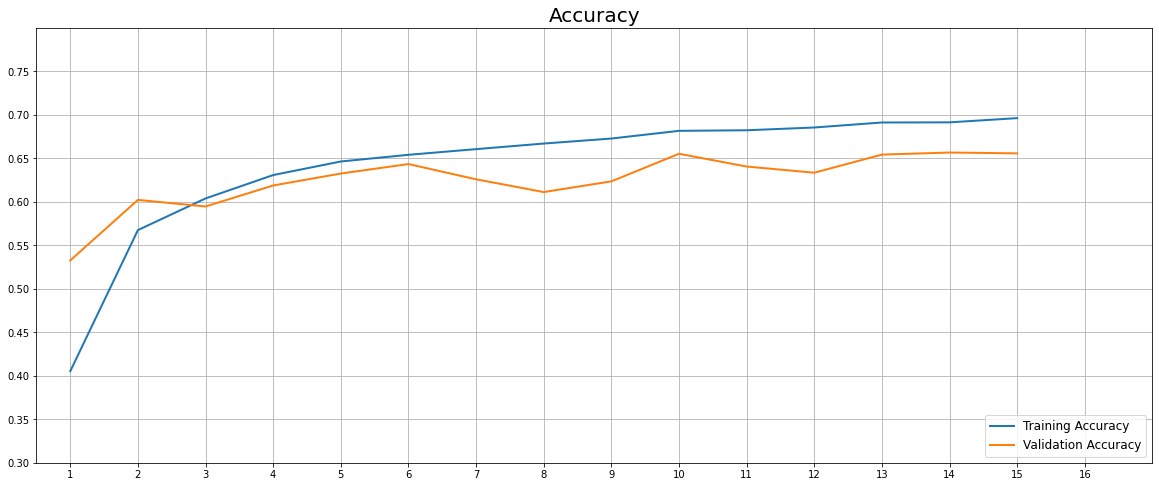

In [35]:
# Plot Accuracy
plt.subplots(figsize=(20,8))
plt.plot(history_df.loc[:, ['accuracy','val_accuracy']], lw=2)
plt.title('Accuracy', fontsize=20)
plt.legend(['Training Accuracy','Validation Accuracy'], fontsize=12, loc=4)
plt.xlim(0.5,17)
plt.ylim(0.45,0.80)
plt.xticks(np.arange(1, 17, step=1))
plt.yticks(np.arange(0.3, 0.80, step=0.05))
plt.grid()
plt.show()

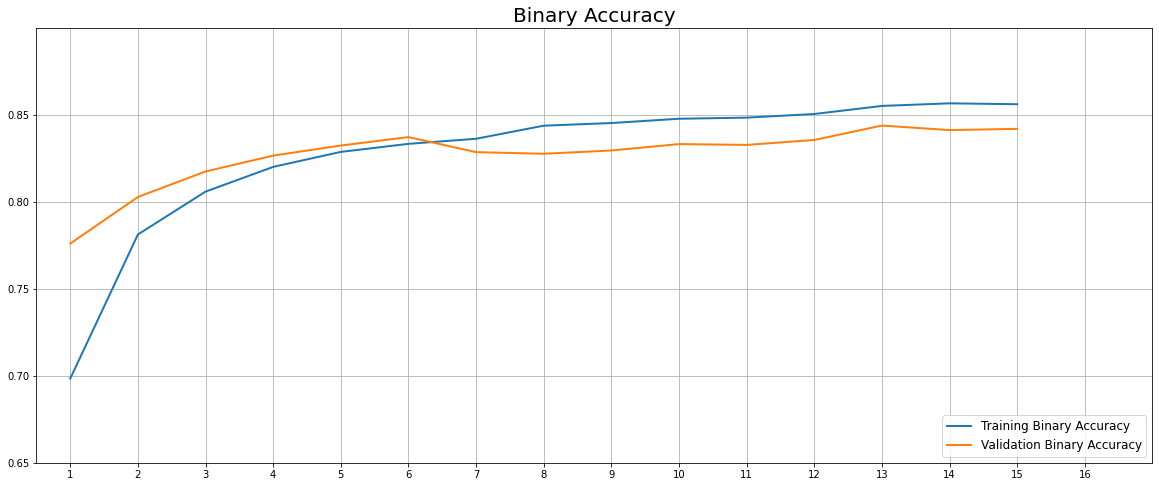

In [38]:
# Plot Binary Accuracy
plt.subplots(figsize=(20,8))
plt.plot(history_df.loc[:, ['binary_accuracy','val_binary_accuracy']], lw=2)
plt.title('Binary Accuracy', fontsize=20)
plt.legend(['Training Binary Accuracy','Validation Binary Accuracy'], fontsize=12, loc=4)
plt.xlim(0.5,17)
plt.ylim(0.65,0.90)
plt.xticks(np.arange(1, 17, step=1))
plt.yticks(np.arange(0.65,0.90, step=0.05))
plt.grid()
plt.show()

In [39]:
# Load model with lowest validation loss 
from keras.models import load_model
saved_model = load_model('/Users/melody/Downloads/[xception]-13-0.345.h5')

In [40]:
# Evaluating against test dataset
y_eval = saved_model.evaluate(valid_generator)
valid_generator.reset()

y_pred = saved_model.predict(valid_generator, verbose=1)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred = pd.DataFrame(y_pred)

y_test = df_train.loc[valid_generator.index_array]

2022-05-30 18:41:39.495491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 9s 231ms/step - loss: 0.3440 - accuracy: 0.6483 - binary_accuracy: 0.8400


2022-05-30 18:41:48.406543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 8s 230ms/step


In [41]:
print(y_eval)

[0.3440054953098297, 0.6483050584793091, 0.8400423526763916]


In [42]:
# Creating confusion matrix
tns, fps, fns, tps = [],[],[],[]

for i in range(4):
    tn, fp, fn, tp = confusion_matrix(list(y_test[i+1]), list(y_pred[i])).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    tns.append(tn)
    fps.append(fp)
    fns.append(fn)
    tps.append(tp)
    print(f'Metrics for Defect {i+1}:')
    print(np.array([[tn, fp],[fn, tp]]))
    print(f'F1       : {2*(precision*recall)/(precision+recall):0.3f}')
    print(f'Recall   : {recall:0.3f}')
    print(f'Precision: {precision:0.3f}')
    print('')
    
precision = sum(tps)/(sum(tps)+sum(fps))
recall = sum(tps)/(sum(tps)+sum(fns))
print('Overall Metrics:')
print(np.array([[sum(tns), sum(fps)],[sum(fns), sum(tps)]]))
print(f'F1       : {2*(precision*recall)/(precision+recall):0.3f}')
print(f'Recall   : {recall:0.3f}')
print(f'Precision: {precision:0.3f}')

Metrics for Defect 1:
[[1154  316]
 [ 491  163]]
F1       : 0.288
Recall   : 0.249
Precision: 0.340

Metrics for Defect 2:
[[1348  360]
 [ 322   94]]
F1       : 0.216
Recall   : 0.226
Precision: 0.207

Metrics for Defect 3:
[[779 395]
 [599 351]]
F1       : 0.414
Recall   : 0.369
Precision: 0.471

Metrics for Defect 4:
[[1102  427]
 [ 421  174]]
F1       : 0.291
Recall   : 0.292
Precision: 0.290

Overall Metrics:
[[4383 1498]
 [1833  782]]
F1       : 0.320
Recall   : 0.299
Precision: 0.343


# VGG16
 

In [43]:
# Creating VGG16 layer
VGG16 = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(71,71,3),
    classes=4
)

In [44]:
for layer in VGG16.layers[:-5]:
    layer.trainable=False

In [45]:
# Building Model
vgg16model=Sequential()
vgg16model.add(VGG16)
vgg16model.add(Dense(128,activation="relu"))
vgg16model.add(Dropout(0.5))
vgg16model.add(Flatten())
vgg16model.add(Dense(128,activation="relu"))
vgg16model.add(Dropout(0.5))
vgg16model.add(Dense(256,activation="relu"))
vgg16model.add(Dropout(0.3))
vgg16model.add(Dense(4,activation="sigmoid"))

In [46]:
# Checking model summary
vgg16model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 dense_4 (Dense)             (None, 2, 2, 128)         65664     
                                                                 
 dropout_3 (Dropout)         (None, 2, 2, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 256)              

In [47]:
# Compiling model
vgg16model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy","binary_accuracy"])

In [48]:
# Creating step size 
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)
print(STEP_SIZE_TEST)

188
33
29


In [49]:
# Fitting model with early stop and saving model to path
callback_list = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='./[vgg]-{epoch:02d}-{val_loss:.3f}.h5'),
]

history = vgg16model.fit(x=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25,
                    callbacks=callback_list,
                    verbose=1)

Epoch 1/25


2022-05-30 18:41:57.481504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - ETA: 0s - loss: 0.5046 - accuracy: 0.4401 - binary_accuracy: 0.7240

2022-05-30 18:42:44.376487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - 56s 293ms/step - loss: 0.5046 - accuracy: 0.4401 - binary_accuracy: 0.7240 - val_loss: 0.4174 - val_accuracy: 0.5336 - val_binary_accuracy: 0.7785
Epoch 2/25
188/188 [==============================] - 56s 296ms/step - loss: 0.4162 - accuracy: 0.5626 - binary_accuracy: 0.7893 - val_loss: 0.3862 - val_accuracy: 0.5923 - val_binary_accuracy: 0.8101
Epoch 3/25
188/188 [==============================] - 55s 293ms/step - loss: 0.3781 - accuracy: 0.6226 - binary_accuracy: 0.8172 - val_loss: 0.3798 - val_accuracy: 0.6136 - val_binary_accuracy: 0.8192
Epoch 4/25
188/188 [==============================] - 57s 303ms/step - loss: 0.3571 - accuracy: 0.6475 - binary_accuracy: 0.8301 - val_loss: 0.3695 - val_accuracy: 0.6151 - val_binary_accuracy: 0.8233
Epoch 5/25
188/188 [==============================] - 57s 302ms/step - loss: 0.3337 - accuracy: 0.6795 - binary_accuracy: 0.8439 - val_loss: 0.3539 - val_accuracy: 0.6402 - val_binary_accuracy: 0.8333
Epoch 

# Results

In [50]:
# Compiling loss and accuracy for every epoch 
history_df = pd.DataFrame(history.history)
history_df.index += 1

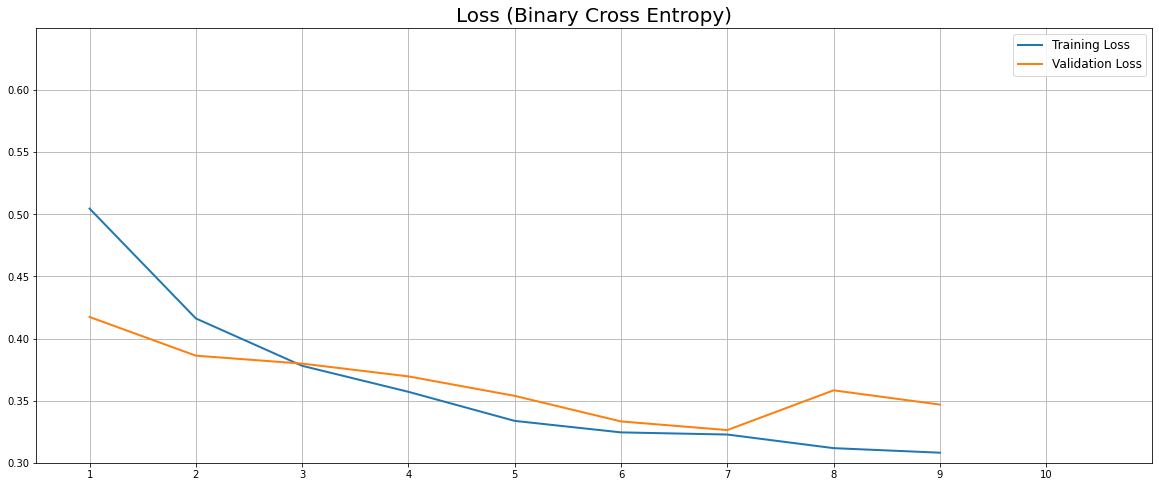

In [51]:
# Plot Loss 
plt.subplots(figsize=(20,8))
plt.plot(history_df.loc[:, ['loss','val_loss']], lw=2)
plt.title('Loss (Binary Cross Entropy)', fontsize=20)
plt.legend(['Training Loss','Validation Loss'], fontsize=12, loc=1)
plt.xlim(0.5,11)
plt.ylim(0.45,0.65)
plt.xticks(np.arange(1, 11, step=1))
plt.yticks(np.arange(0.3, 0.65, step=0.05))
plt.grid()
plt.show()

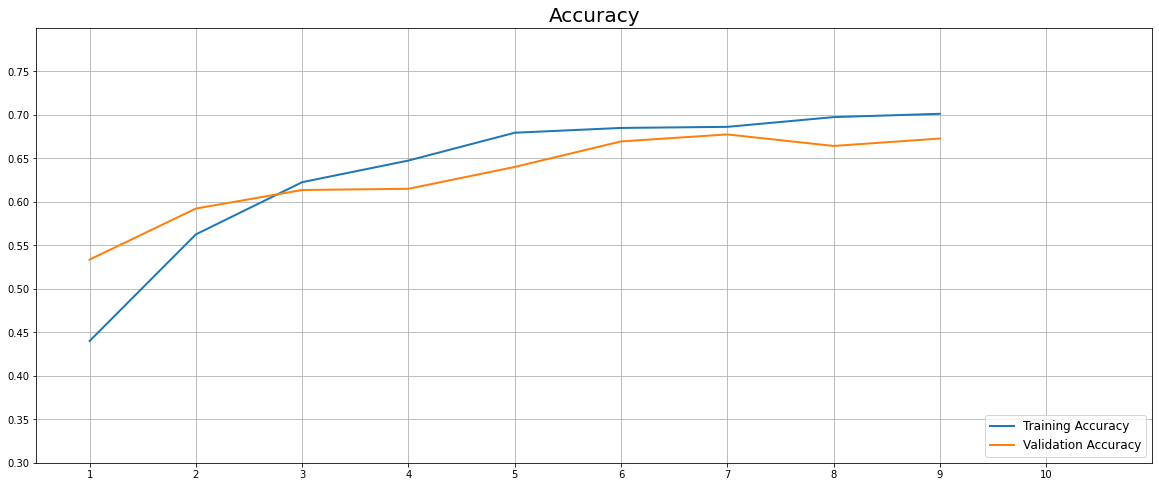

In [53]:
# Plot Accuracy 
plt.subplots(figsize=(20,8))
plt.plot(history_df.loc[:, ['accuracy','val_accuracy']], lw=2)
plt.title('Accuracy', fontsize=20)
plt.legend(['Training Accuracy','Validation Accuracy'], fontsize=12, loc=4)
plt.xlim(0.5,11)
plt.ylim(0.45,0.8)
plt.xticks(np.arange(1, 11, step=1))
plt.yticks(np.arange(0.3, 0.8, step=0.05))
plt.grid()
plt.show()

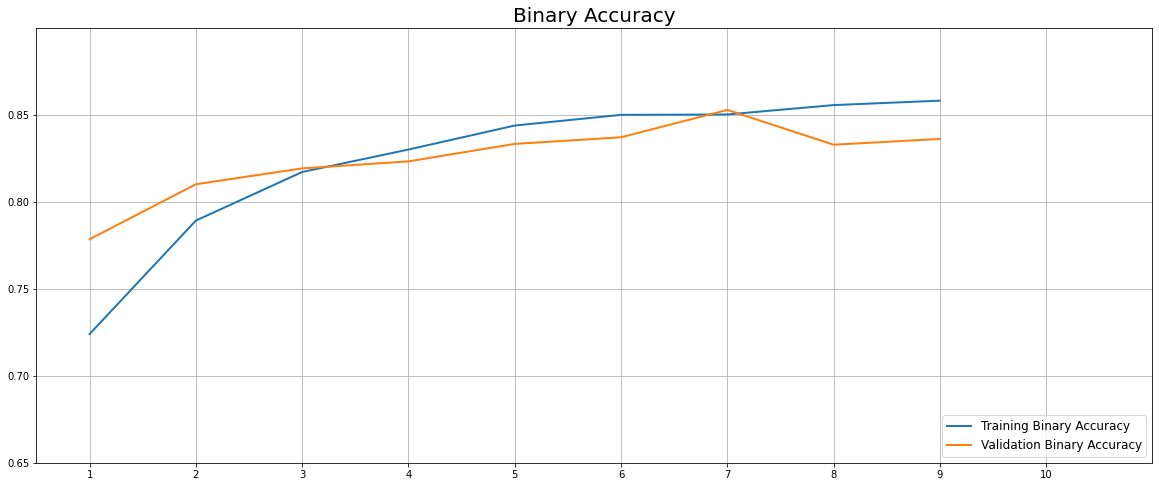

In [55]:
# Plot Binary Accuracy 
plt.subplots(figsize=(20,8))
plt.plot(history_df.loc[:, ['binary_accuracy','val_binary_accuracy']], lw=2)
plt.title('Binary Accuracy', fontsize=20)
plt.legend(['Training Binary Accuracy','Validation Binary Accuracy'], fontsize=12, loc=4)
plt.xlim(0.5,11)
plt.ylim(0.65,0.9)
plt.xticks(np.arange(1, 11, step=1))
plt.yticks(np.arange(0.65,0.9, step=0.05))
plt.grid()
plt.show()

In [56]:
# Load model with lowest validation loss 
from keras.models import load_model
saved_model = load_model('/Users/melody/Downloads/[vgg]-07-0.326.h5')

In [57]:
# Evaluating against test dataset
y_eval = saved_model.evaluate(valid_generator)
valid_generator.reset()

y_pred = saved_model.predict(valid_generator, verbose=1)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred = pd.DataFrame(y_pred)

y_test = df_train.loc[valid_generator.index_array]

2022-05-30 18:57:08.498477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 9s 238ms/step - loss: 0.3315 - accuracy: 0.6756 - binary_accuracy: 0.8465


2022-05-30 18:57:17.561051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 8s 230ms/step


In [58]:
print(y_eval)

[0.3315325677394867, 0.6756120324134827, 0.8465160131454468]


In [59]:
# Creating Confusion Matrix
tns, fps, fns, tps = [],[],[],[]

for i in range(4):
    tn, fp, fn, tp = confusion_matrix(list(y_test[i+1]), list(y_pred[i])).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    tns.append(tn)
    fps.append(fp)
    fns.append(fn)
    tps.append(tp)
    print(f'Metrics for Defect {i+1}:')
    print(np.array([[tn, fp],[fn, tp]]))
    print(f'F1       : {2*(precision*recall)/(precision+recall):0.3f}')
    print(f'Recall   : {recall:0.3f}')
    print(f'Precision: {precision:0.3f}')
    print('')
    
precision = sum(tps)/(sum(tps)+sum(fps))
recall = sum(tps)/(sum(tps)+sum(fns))
print('Overall Metrics:')
print(np.array([[sum(tns), sum(fps)],[sum(fns), sum(tps)]]))
print(f'F1       : {2*(precision*recall)/(precision+recall):0.3f}')
print(f'Recall   : {recall:0.3f}')
print(f'Precision: {precision:0.3f}')

Metrics for Defect 1:
[[1130  340]
 [ 497  157]]
F1       : 0.273
Recall   : 0.240
Precision: 0.316

Metrics for Defect 2:
[[1329  379]
 [ 335   81]]
F1       : 0.185
Recall   : 0.195
Precision: 0.176

Metrics for Defect 3:
[[750 424]
 [608 342]]
F1       : 0.399
Recall   : 0.360
Precision: 0.446

Metrics for Defect 4:
[[1169  360]
 [ 464  131]]
F1       : 0.241
Recall   : 0.220
Precision: 0.267

Overall Metrics:
[[4378 1503]
 [1904  711]]
F1       : 0.294
Recall   : 0.272
Precision: 0.321


# ResNet50

In [60]:
# Creating ResNet50 layer
ResNet50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(71,71,3),
    classes=4
)

In [61]:
for layer in ResNet50.layers[:-5]:
    layer.trainable=False

In [62]:
# Building Model
resnet50model=Sequential()
resnet50model.add(ResNet50)
resnet50model.add(Dense(128,activation="relu"))
resnet50model.add(Dropout(0.5))
resnet50model.add(Flatten())
resnet50model.add(Dense(128,activation="relu"))
resnet50model.add(Dropout(0.5))
resnet50model.add(Dense(256,activation="relu"))
resnet50model.add(Dropout(0.3))
resnet50model.add(Dense(4,activation="sigmoid"))

In [63]:
# Checking model summary
resnet50model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 dense_8 (Dense)             (None, 3, 3, 128)         262272    
                                                                 
 dropout_6 (Dropout)         (None, 3, 3, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 1152)              0         
                                                                 
 dense_9 (Dense)             (None, 128)               147584    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 256)              

In [64]:
# Compiling model
resnet50model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy","binary_accuracy"])

In [65]:
# Creating step size 
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)
print(STEP_SIZE_TEST)

188
33
29


In [66]:
# Fitting model with early stop and saving model to path
callback_list = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='./[res50]-{epoch:02d}-{val_loss:.3f}.h5'),
]

history = resnet50model.fit(x=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25,
                    callbacks=callback_list,
                    verbose=1)

Epoch 1/25


2022-05-30 18:57:29.242544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - ETA: 0s - loss: 0.6032 - accuracy: 0.3520 - binary_accuracy: 0.6919

2022-05-30 18:58:17.251297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - 59s 296ms/step - loss: 0.6032 - accuracy: 0.3520 - binary_accuracy: 0.6919 - val_loss: 0.6051 - val_accuracy: 0.3821 - val_binary_accuracy: 0.6921
Epoch 2/25
188/188 [==============================] - 54s 287ms/step - loss: 0.5756 - accuracy: 0.3675 - binary_accuracy: 0.6995 - val_loss: 0.6081 - val_accuracy: 0.3471 - val_binary_accuracy: 0.6921
Epoch 3/25
188/188 [==============================] - 59s 312ms/step - loss: 0.5561 - accuracy: 0.3814 - binary_accuracy: 0.7031 - val_loss: 0.5611 - val_accuracy: 0.3778 - val_binary_accuracy: 0.7022
Epoch 4/25
188/188 [==============================] - 58s 307ms/step - loss: 0.5457 - accuracy: 0.3905 - binary_accuracy: 0.7023 - val_loss: 0.5444 - val_accuracy: 0.4152 - val_binary_accuracy: 0.6927
Epoch 5/25
188/188 [==============================] - 58s 306ms/step - loss: 0.5420 - accuracy: 0.3966 - binary_accuracy: 0.7042 - val_loss: 0.5357 - val_accuracy: 0.4138 - val_binary_accuracy: 0.6980
Epoch 

# Results

In [67]:
# Compiling loss and accuracy for every epoch 
history_df = pd.DataFrame(history.history)
history_df.index += 1

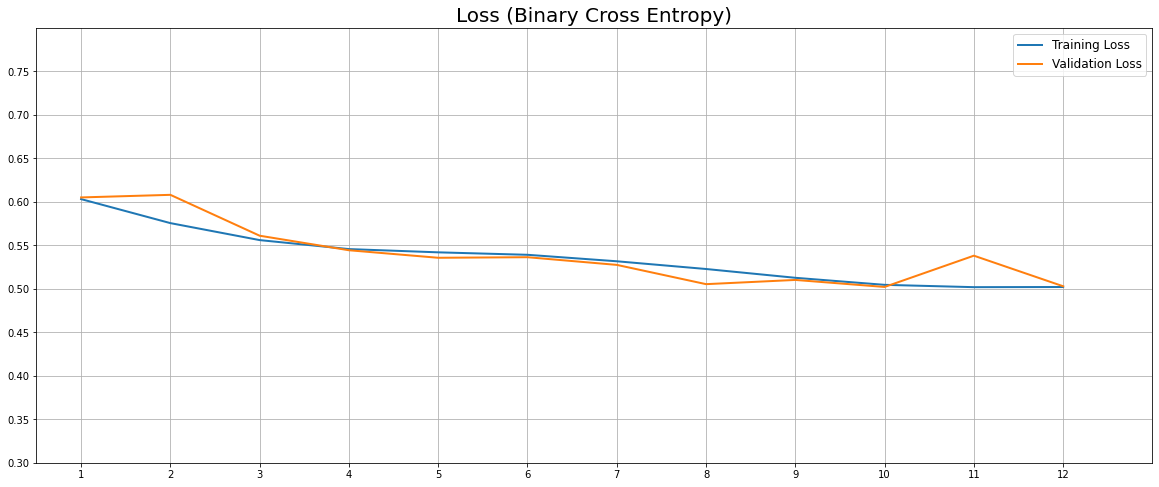

In [71]:
# Plot Loss 
plt.subplots(figsize=(20,8))
plt.plot(history_df.loc[:, ['loss','val_loss']], lw=2)
plt.title('Loss (Binary Cross Entropy)', fontsize=20)
plt.legend(['Training Loss','Validation Loss'], fontsize=12, loc=1)
plt.xlim(0.5,13)
plt.ylim(0.45,0.8)
plt.xticks(np.arange(1, 13, step=1))
plt.yticks(np.arange(0.3, 0.8, step=0.05))
plt.grid()
plt.show()

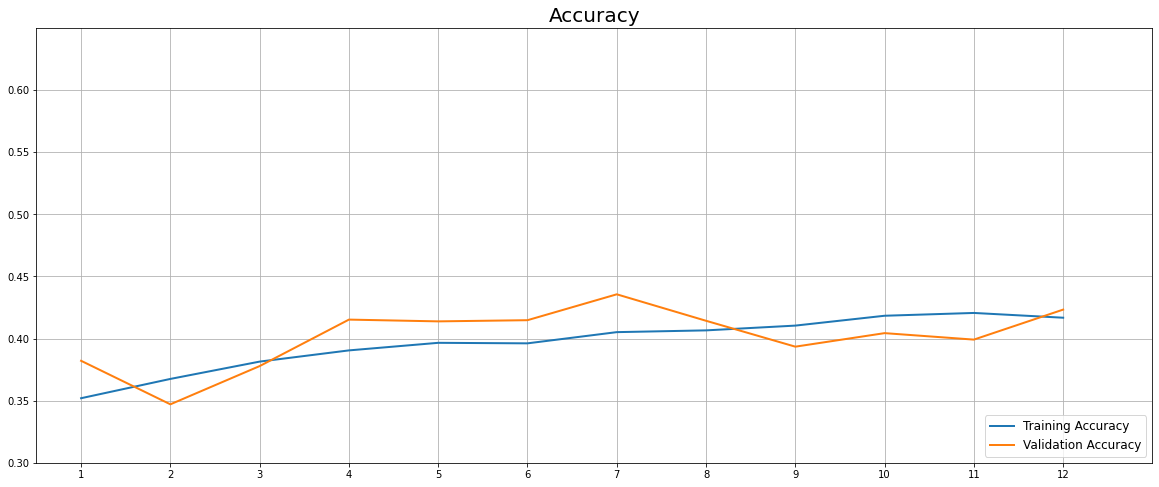

In [73]:
# Plot Accuracy 
plt.subplots(figsize=(20,8))
plt.plot(history_df.loc[:, ['accuracy','val_accuracy']], lw=2)
plt.title('Accuracy', fontsize=20)
plt.legend(['Training Accuracy','Validation Accuracy'], fontsize=12, loc=4)
plt.xlim(0.5,13)
plt.ylim(0.45,0.65)
plt.xticks(np.arange(1, 13, step=1))
plt.yticks(np.arange(0.3, 0.65, step=0.05))
plt.grid()
plt.show()

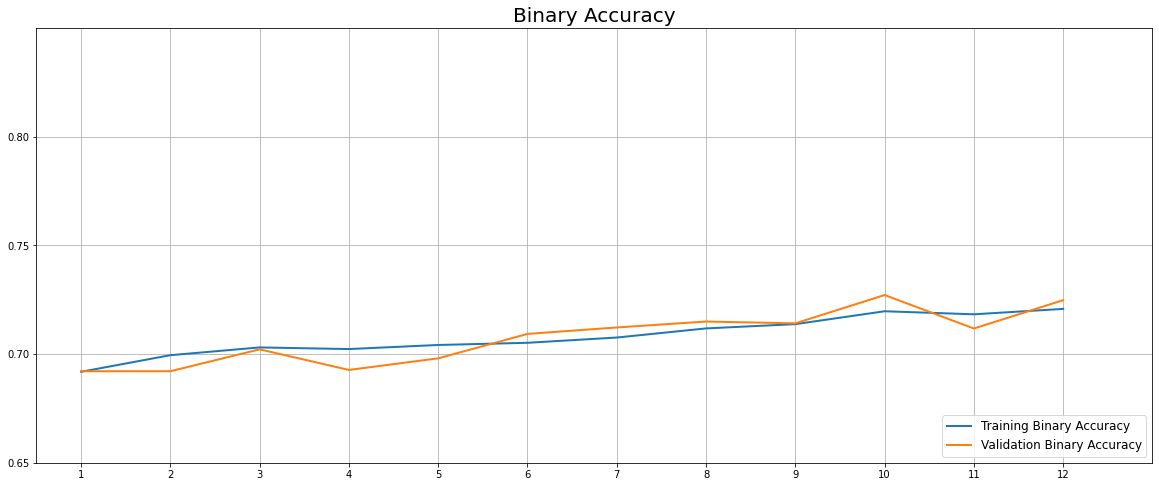

In [75]:
# Plot Binary Accuracy 
plt.subplots(figsize=(20,8))
plt.plot(history_df.loc[:, ['binary_accuracy','val_binary_accuracy']], lw=2)
plt.title('Binary Accuracy', fontsize=20)
plt.legend(['Training Binary Accuracy','Validation Binary Accuracy'], fontsize=12, loc=4)
plt.xlim(0.5,13)
plt.ylim(0.65,0.85)
plt.xticks(np.arange(1, 13, step=1))
plt.yticks(np.arange(0.65,0.85, step=0.05))
plt.grid()
plt.show()

In [76]:
# Load model with lowest validation loss 
from keras.models import load_model
saved_model = load_model('/Users/melody/Downloads/[res50]-10-0.502.h5')

In [77]:
# Evaluating against test dataset
y_eval = saved_model.evaluate(valid_generator)
valid_generator.reset()

y_pred = saved_model.predict(valid_generator, verbose=1)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred = pd.DataFrame(y_pred)

y_test = df_train.loc[valid_generator.index_array]

2022-05-30 19:11:10.289451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 9s 236ms/step - loss: 0.5001 - accuracy: 0.4176 - binary_accuracy: 0.7294


2022-05-30 19:11:20.784690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 10s 233ms/step


In [78]:
print(y_eval)

[0.500125527381897, 0.4176082909107208, 0.7294020652770996]


In [79]:
# Creating confusion matrix
tns, fps, fns, tps = [],[],[],[]

for i in range(4):
    tn, fp, fn, tp = confusion_matrix(list(y_test[i+1]), list(y_pred[i])).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    tns.append(tn)
    fps.append(fp)
    fns.append(fn)
    tps.append(tp)
    print(f'Metrics for Defect {i+1}:')
    print(np.array([[tn, fp],[fn, tp]]))
    print(f'F1       : {2*(precision*recall)/(precision+recall):0.3f}')
    print(f'Recall   : {recall:0.3f}')
    print(f'Precision: {precision:0.3f}')
    print('')
    
precision = sum(tps)/(sum(tps)+sum(fps))
recall = sum(tps)/(sum(tps)+sum(fns))
print('Overall Metrics:')
print(np.array([[sum(tns), sum(fps)],[sum(fns), sum(tps)]]))
print(f'F1       : {2*(precision*recall)/(precision+recall):0.3f}')
print(f'Recall   : {recall:0.3f}')
print(f'Precision: {precision:0.3f}')

Metrics for Defect 1:
[[1454   16]
 [ 653    1]]
F1       : 0.003
Recall   : 0.002
Precision: 0.059

Metrics for Defect 2:
[[1528  180]
 [ 364   52]]
F1       : 0.160
Recall   : 0.125
Precision: 0.224

Metrics for Defect 3:
[[824 350]
 [675 275]]
F1       : 0.349
Recall   : 0.289
Precision: 0.440

Metrics for Defect 4:
[[1197  332]
 [ 443  152]]
F1       : 0.282
Recall   : 0.255
Precision: 0.314

Overall Metrics:
[[5003  878]
 [2135  480]]
F1       : 0.242
Recall   : 0.184
Precision: 0.353
